In [The Mean and Slopes](mean_and_slopes), we used a simple but slow way to
find the slope that best predicted one vector of values from another vector of
values.

First we go back to find that slope.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Make plots look a little bit more fancy
plt.style.use('fivethirtyeight')
# Print to 2 decimal places, show tiny values as 0
np.set_printoptions(precision=2, suppress=True)
import pandas as pd

Download the [ckd_clean.csv]({{ site.baseurl }}/data/ckd_clean.csv) file to the
same directory as this notebook, if you are running on your own computer.

We fetch and process the data. See [mean and slopes](mean_and_slopes) for a slower description of this processing.

In [2]:
# Load the data file
ckd = pd.read_csv('ckd_clean.csv')
pcv = np.array(ckd['Packed Cell Volume'])
hgb = np.array(ckd['Hemoglobin'])

Our criterion is the sum of squared error:

In [3]:
def sos_error(slope):
    fitted = hgb * slope  # 'hgb' comes from the top level
    error = pcv - fitted     # 'pcv' comes from the top level
    return np.sum(error ** 2)

We found the best slope by trying a very large number of slopes, and recording,
for each slope, the sum of squared error.  We chose the slope from the slopes
that we tried, that gave us the lowest sum of squared error.

In [4]:
# Slopes to try
some_slopes = np.arange(2, 4, 0.01)
n_slopes = len(some_slopes)
# Try all these slopes, calculate and record sum of squared error
sos_errors = np.zeros(n_slopes)
for i in np.arange(n_slopes):
    slope = some_slopes[i]
    sos_errors[i] = sos_error(slope)
# The slope minimizing the sum of squared error
best_slope = some_slopes[np.argmin(sos_errors)]
best_slope

3.0499999999999776

At the end, of [the mean and slopes](mean_and_slopes) notebook, we saw that
a function in Scipy called `minimize` can do this work for us, relatively
quickly.

In [5]:
from scipy.optimize import minimize
minimize(sos_error, 3)

      fun: 3619.6157878183294
 hess_inv: array([[0.]])
      jac: array([0.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 16
      nit: 2
     njev: 5
   status: 2
  success: False
        x: array([3.05])

What we are doing, with our slow dumb technique, and with the `minimize`
function, is something called [mathematical
optimization](https://en.wikipedia.org/wiki/Mathematical_optimization).  We use
*optimization* when we have some *function* that takes one or more
*parameters*.  We want to chose, or *optimize* the parameters to give us some
desired output from the function.

In our case our *function* is the sum of squared error, `sos_error`.  The
*parameter* is the slope.  We are trying to find the value for the parameter
that *minimizes* the result of calling the function `sos_error`.

One way of doing this minimization, is the slow dumb way.  We just try a huge
number of values for the parameter (the slope), and chose the value that gives
us the lowest output value (the sum of squared error).

This is such a common problem, that there has been an enormous amount of
theoretical and practical work on building algorithms to make process of
searching for the minimum value more efficient.

This notebook is to give you an idea of how you might do this, and therefore,
the kind of things that `minimize` can do, to search quickly for the best
parameter.

Let's look again at the shape of the curve relating the slope to the sum of
squared error:

Text(0.5, 1.0, 'SSE as a function of slope')

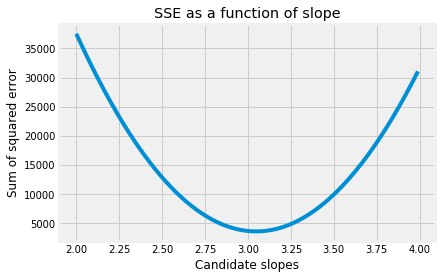

In [6]:
plt.plot(some_slopes, sos_errors)
plt.xlabel('Candidate slopes')
plt.ylabel('Sum of squared error')
plt.title('SSE as a function of slope')

This is the *function* we are trying minimize.  Specifically, we are trying to
optimize the function that gives the *SSE* as a function of the *slope*
parameter.

We want to avoid trying every possible value for the slope.

To do this, we are going to start with one value for the slope, say 100, then
see if there is a good way to chose the next value to try.

Looking at the graph, we see that, when the slope is far away from the minimum, the sum of squared error (on the y axis) changes very quickly as the slope changes.  That is, the function has a steep *gradient*.

Maybe we could check what the gradient is, at our starting value of 100, by
calculating the sum of squares (y) value, and then calculating the sum of
squares (y) value when we increase the slope by a tiny amount.  This is the
change in y for a very small change in x.  We divide the change in y by the
change in x, to get the gradient:

In [7]:
def sos_error_gradient(x, dx=0.0001):
    # Gradient of the sos_error at this value of x
    # sos_error at this x value.
    sos_0 = sos_error(x)
    # sos_error a tiny bit to the right on the x axis.
    sos_1 = sos_error(x + dx)
    # gradient is y difference divided by x difference.
    return (sos_1 - sos_0) / dx

In [8]:
# The y value of the function.
sos_error(4)

31657.96

In [9]:
# The gradient of the function at this point.
sos_error_gradient(4)

58876.17044587387

A large positive gradient means the x value (slope) that we tried is still far
to the *right* of the minimum. This might encourage us to try an x value that
is well to the left.  We could call this a large step in x, and therefore
a large *step size*.

Let's try another value:

In [10]:
# The y value of the function.
sos_error(2)

37529.64

In [11]:
# The gradient of the function at this point.
sos_error_gradient(2)

-64741.669554132386

A large negative gradient means the x value (slope) that we tried is still far
to the *left* of the minimum.   This might encourage us to try an x value that
is well to the right.

As the gradients get small, we want to take smaller steps, so we don't miss the
minimum.

The general idea then, is to chose our step sizes in proportion to the gradient
of the function.

This is the optimization technique known as [gradient
descent](https://en.wikipedia.org/wiki/Gradient_descent).

Here it is in action, using code modified from the Wikipedia page above.

We try new x (slope) values by making big jumps when the gradient is steep, and
small jumps when the gradient is shallow.

In [12]:
next_x = 4 # We start the search at x=4
gamma = 0.00001 # Step size multiplier
precision = 0.00001 # Desired precision of result
max_iters = 1000 # Maximum number of iterations

for i in np.arange(max_iters):
    # Go to the next x value
    current_x = next_x
    # Estimate the gradient
    gradient = sos_error_gradient(current_x)
    # Use gradient to choose the next x value to try.
    # This takes negative steps when the gradient is positive
    # and positive steps when the gradient is negative.
    next_x = current_x - gamma * gradient
    step = next_x - current_x
    print('x: {:0.5f}; step {:0.5f}; gradient {:0.2f}'.format(
        current_x, step, gradient))
    # When the step size is equal to or smaller than the desired
    # precision, we are near enough.
    if abs(step) <= precision:
        # Break out of the loop.
        break

print("Minimum at", next_x)

x: 4.00000; step -0.58876; gradient 58876.17
x: 3.41124; step -0.22485; gradient 22485.45
x: 3.18638; step -0.08587; gradient 8587.43
x: 3.10051; step -0.03280; gradient 3279.63
x: 3.06771; step -0.01253; gradient 1252.53
x: 3.05519; step -0.00478; gradient 478.35
x: 3.05040; step -0.00183; gradient 182.69
x: 3.04858; step -0.00070; gradient 69.77
x: 3.04788; step -0.00027; gradient 26.65
x: 3.04761; step -0.00010; gradient 10.18
x: 3.04751; step -0.00004; gradient 3.89
x: 3.04747; step -0.00001; gradient 1.48
x: 3.04746; step -0.00001; gradient 0.57
Minimum at 3.0474521484512476


As you can see, by doing this, we save ourselves from trying a very large
number of other potential x values (slopes), and we focus in on the minimum
very quickly.

This is just one method among many for optimizing our search for the minimum of
a function.  Now you know what kind of thing it is doing, we will just let
`miminize` do its job for us:

In [13]:
# Use float to show us the final result in higher precision
result = minimize(sos_error, 100)
float(result.x)

3.0474986373317794